# KALRNA: Scoring initial poses

## 1. Scoring 3D aligned structures (fragment-based approach)
To evaluate the quality of the alignments produced (see 20190626-KALRNA_genetate_initial_confs), two scores were used to compare the aligned conformations for each follow-up candidate to their respective hit molecule:
- SuCOS score: The SuCOS score is an open-source shape and chemical feature overlap metric
- Tanimoto shape similarity: This score compares the similarity in shape between two molecules

The best conformation for each score is taken as the best initial geometry guess for each candidate molecule.

The results, indicating the best conformation for each candidate molecule for both the 'surprise' and 'similar' sets are returned as a dictionary, which can be displayed and manipulated by pandas. The dictionary gives the best score for each of the two scores described, the conformer-containing sdf file, and the index of the molecule in the sdf file for both scores, so that the conformations can be easily accessed from the original aligned conformer sdf file

### Code (adapted from https://bitbucket.org/Susanhleung/sucos/src/master/calc_SuCOS.py):

In [1]:
import argparse, os, gzip
import glob
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit import RDConfig
from rdkit.Chem import Draw
from joblib import Parallel, delayed
import multiprocessing
import operator

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def get_FeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    featLists = []
    for m in [small_m, large_m]:
        rawFeats = fdef.GetFeaturesForMol(m)
        # filter that list down to only include the ones we're intereted in
        featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    fms[0].scoreMode = score_mode
    fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
    return fm_score

def sucos_mol_to_mol(mol1, mol2, score_mode=FeatMaps.FeatMapScoreMode.All):
    ref = Chem.AddHs(mol1)
    prb = Chem.AddHs(mol2)
    
    fm_score = get_FeatureMapScore(ref, prb, score_mode)
    fm_score = np.clip(fm_score, 0, 1)

    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
            allowReordering=False)
    protrude_dist = np.clip(protrude_dist, 0, 1)

    SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
    
    return SuCOS_score


def score(ref_file, prb_file, score_mode=FeatMaps.FeatMapScoreMode.All, p=False):
    reflig = Chem.MolFromMolFile(ref_file, sanitize=True)
    ref = Chem.AddHs(reflig)
    prb_mols = Chem.SDMolSupplier(prb_file, sanitize=True)
    prb_mols = [x for x in prb_mols if x]
    idx = 0
    
    results_sucos = {}
    results_tani = {}
    
    smi_mol = Chem.MolToSmiles(prb_mols[0])
    
    for prb_mol in prb_mols:
        
        prb = Chem.AddHs(prb_mol)
                
        fm_score = get_FeatureMapScore(ref, prb, score_mode)
        fm_score = np.clip(fm_score, 0, 1)
        
        protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
                allowReordering=False)
        protrude_dist = np.clip(protrude_dist, 0, 1)
        
        SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
        tanimoto_score = Chem.rdShapeHelpers.ShapeTanimotoDist(ref, prb)
        
        results_sucos[str(idx)] = SuCOS_score
        results_tani[str(idx)] = tanimoto_score
        
        if p:
        
            print ("********************************")
            print ("index: " + str(idx))
            print ("SuCOS score:\t%f" % SuCOS_score)
            print ("Tani score:\t%f" % tanimoto_score)
            print ("********************************")
        
        idx+=1

    return results_sucos, results_tani, smi_mol, prb_mols, reflig


def select_highest(results, number):
    ids = []
    r = results
    while len(ids)<number:
        i = max(results.items(), key=operator.itemgetter(1))[0]
        ids.append(int(i))
        r.pop(i, None)
    return ids

def select_lowest(results, number):
    ids = []
    r = results
    while len(ids)<number:
        i = min(results.items(), key=operator.itemgetter(1))[0]
        ids.append(int(i))
        r.pop(i, None)
    return ids

def score_all_confs(hit_file_directory, initial_hit, all_confs_paths):

    all_results_dict = {
        'candidate_name': [],
        'candidate_smiles': [],
        'candidate_conformers_file': [],
        'initial_hit': [],
        'best_sucos': [],
        'best_sucos_id': [],
        'best_tanimoto': [],
        'best_tanimoto_id': [],
    }
    
    for i in range(0, len(all_confs_paths)):
        results_sucos, results_tani, smiles, prb_mols, reflig = score(ref_file=initial_hit, prb_file=all_confs_paths[i])
        print('running ' + str(i) + '/' + str(len(all_confs_paths)))
        # best sucos socre and id
        r = results_sucos.copy()
        idx = select_highest(r, 1)[0]
        sucos_score = results_sucos[str(idx)]
        # best tanimoto socre and id
        s = results_tani.copy()
        idy = select_lowest(s, 1)[0]
        tani_score = results_tani[str(idy)]

        all_results_dict['candidate_name'].append(all_confs_paths[i].split('/')[-1].replace('_confs_aligned.sdf', ''))
        all_results_dict['candidate_smiles'].append(smiles)
        all_results_dict['candidate_conformers_file'].append(all_confs_paths[i])
        all_results_dict['initial_hit'].append(initial_hit.split('/')[-1])
        all_results_dict['best_sucos'].append(sucos_score)
        all_results_dict['best_sucos_id'].append(idx)
        all_results_dict['best_tanimoto'].append(tani_score)
        all_results_dict['best_tanimoto_id'].append(idy)

    return all_results_dict

In [2]:
hit_file_directory = '/data/GDP_frags/GDP_frag2'
initial_hit = '/data/GDP_frags/GDP.sdf'
all_confs_paths = glob.glob(os.path.join(hit_file_directory, '*_confs_aligned.sdf'))
print(all_confs_paths)

all_results_dict = score_all_confs(hit_file_directory=hit_file_directory, 
                                   initial_hit=initial_hit, 
                                   all_confs_paths=all_confs_paths)

['/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-rsn_535_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_74_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_664_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_983_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_499_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_303_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-rsn_786_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-rsn_861_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_780_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_867_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-rsn_42_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rsn_829_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-rsn_305_confs_aligned.sdf', '/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs

running 0/1998
running 1/1998
running 2/1998
running 3/1998
running 4/1998
running 5/1998
running 6/1998
running 7/1998
running 8/1998
running 9/1998
running 10/1998
running 11/1998
running 12/1998
running 13/1998
running 14/1998
running 15/1998
running 16/1998
running 17/1998
running 18/1998
running 19/1998
running 20/1998
running 21/1998
running 22/1998
running 23/1998
running 24/1998
running 25/1998
running 26/1998
running 27/1998
running 28/1998
running 29/1998
running 30/1998
running 31/1998
running 32/1998
running 33/1998
running 34/1998
running 35/1998
running 36/1998
running 37/1998
running 38/1998
running 39/1998
running 40/1998
running 41/1998
running 42/1998
running 43/1998
running 44/1998
running 45/1998
running 46/1998
running 47/1998
running 48/1998
running 49/1998
running 50/1998
running 51/1998
running 52/1998
running 53/1998
running 54/1998
running 55/1998
running 56/1998
running 57/1998
running 58/1998
running 59/1998
running 60/1998
running 61/1998
running 62/1998
ru

running 489/1998
running 490/1998
running 491/1998
running 492/1998
running 493/1998
running 494/1998
running 495/1998
running 496/1998
running 497/1998
running 498/1998
running 499/1998
running 500/1998
running 501/1998
running 502/1998
running 503/1998
running 504/1998
running 505/1998
running 506/1998
running 507/1998
running 508/1998
running 509/1998
running 510/1998
running 511/1998
running 512/1998
running 513/1998
running 514/1998
running 515/1998
running 516/1998
running 517/1998
running 518/1998
running 519/1998
running 520/1998
running 521/1998
running 522/1998
running 523/1998
running 524/1998
running 525/1998
running 526/1998
running 527/1998
running 528/1998
running 529/1998
running 530/1998
running 531/1998
running 532/1998
running 533/1998
running 534/1998
running 535/1998
running 536/1998
running 537/1998
running 538/1998
running 539/1998
running 540/1998
running 541/1998
running 542/1998
running 543/1998
running 544/1998
running 545/1998
running 546/1998
running 547/19

running 971/1998
running 972/1998
running 973/1998
running 974/1998
running 975/1998
running 976/1998
running 977/1998
running 978/1998
running 979/1998
running 980/1998
running 981/1998
running 982/1998
running 983/1998
running 984/1998
running 985/1998
running 986/1998
running 987/1998
running 988/1998
running 989/1998
running 990/1998
running 991/1998
running 992/1998
running 993/1998
running 994/1998
running 995/1998
running 996/1998
running 997/1998
running 998/1998
running 999/1998
running 1000/1998
running 1001/1998
running 1002/1998
running 1003/1998
running 1004/1998
running 1005/1998
running 1006/1998
running 1007/1998
running 1008/1998
running 1009/1998
running 1010/1998
running 1011/1998
running 1012/1998
running 1013/1998
running 1014/1998
running 1015/1998
running 1016/1998
running 1017/1998
running 1018/1998
running 1019/1998
running 1020/1998
running 1021/1998
running 1022/1998
running 1023/1998
running 1024/1998
running 1025/1998
running 1026/1998
running 1027/1998
run

running 1428/1998
running 1429/1998
running 1430/1998
running 1431/1998
running 1432/1998
running 1433/1998
running 1434/1998
running 1435/1998
running 1436/1998
running 1437/1998
running 1438/1998
running 1439/1998
running 1440/1998
running 1441/1998
running 1442/1998
running 1443/1998
running 1444/1998
running 1445/1998
running 1446/1998
running 1447/1998
running 1448/1998
running 1449/1998
running 1450/1998
running 1451/1998
running 1452/1998
running 1453/1998
running 1454/1998
running 1455/1998
running 1456/1998
running 1457/1998
running 1458/1998
running 1459/1998
running 1460/1998
running 1461/1998
running 1462/1998
running 1463/1998
running 1464/1998
running 1465/1998
running 1466/1998
running 1467/1998
running 1468/1998
running 1469/1998
running 1470/1998
running 1471/1998
running 1472/1998
running 1473/1998
running 1474/1998
running 1475/1998
running 1476/1998
running 1477/1998
running 1478/1998
running 1479/1998
running 1480/1998
running 1481/1998
running 1482/1998
running 14

running 1884/1998
running 1885/1998
running 1886/1998
running 1887/1998
running 1888/1998
running 1889/1998
running 1890/1998
running 1891/1998
running 1892/1998
running 1893/1998
running 1894/1998
running 1895/1998
running 1896/1998
running 1897/1998
running 1898/1998
running 1899/1998
running 1900/1998
running 1901/1998
running 1902/1998
running 1903/1998
running 1904/1998
running 1905/1998
running 1906/1998
running 1907/1998
running 1908/1998
running 1909/1998
running 1910/1998
running 1911/1998
running 1912/1998
running 1913/1998
running 1914/1998
running 1915/1998
running 1916/1998
running 1917/1998
running 1918/1998
running 1919/1998
running 1920/1998
running 1921/1998
running 1922/1998
running 1923/1998
running 1924/1998
running 1925/1998
running 1926/1998
running 1927/1998
running 1928/1998
running 1929/1998
running 1930/1998
running 1931/1998
running 1932/1998
running 1933/1998
running 1934/1998
running 1935/1998
running 1936/1998
running 1937/1998
running 1938/1998
running 19

### 1.1 Evaluating the scores of aligned conformers

The results dictionary from above can be displayed by pandas. Showing the resulting data, sorted on 'best_sucos' shows that (according to sucos) the molecules we have generated are very similar, in shape and feature, to the starting hit molecule.

We can also see that the majority of the top ranked compounds are from the 'similar' set - which is to be expected. To add some diversity to the molecules that will be investigated further, the two sets have been separated back out for analysis (and the results saved out as csv files so we can look again later).

In [3]:
import pandas as pd
# create dataframe from results of scoring alignments
df = pd.DataFrame.from_dict(all_results_dict)

# top 500 compounds from each search set(similar/surprise) and score(sucos/tanimoto)
best_sucos_similar = df[df['candidate_name'].str.contains("similar")].sort_values(by=['best_sucos'], ascending=False).head(500)
best_tanimoto_similar = df[df['candidate_name'].str.contains("similar")].sort_values(by=['best_tanimoto'], ascending=True).head(500)
best_sucos_surprise = df[df['candidate_name'].str.contains("surprise")].sort_values(by=['best_sucos'], ascending=False).head(500)
best_tanimoto_surprise = df[df['candidate_name'].str.contains("surprise")].sort_values(by=['best_tanimoto'], ascending=True).head(500)

# save the top 500 as csv files
best_sucos_similar.to_csv('/data/GDP_frags/GDP_frag2/500_similar_sucos.csv')
best_tanimoto_similar.to_csv('/data/GDP_frags/GDP_frag2/500_similar_tanimoto.csv')
best_sucos_surprise.to_csv('/data/GDP_frags/GDP_frag2/500_surprise_sucos.csv')
best_tanimoto_surprise.to_csv('/data/GDP_frags/GDP_frag2/500_surprise_tanimoto.csv')

# display results frame
df.sort_values(by=['best_sucos'], ascending=False)

,candidate_name,candidate_smiles,candidate_conformers_file,initial_hit,best_sucos,best_sucos_id,best_tanimoto,best_tanimoto_id
730,GDP_frag2-similar-rsn_566,CNC(=S)N1CCOC(C(F)(F)F)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.662476,83,0.566098,12
1364,GDP_frag2-similar-rsn_610,CNC(=S)N1CC(CO)OC(C(F)(F)F)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.650553,61,0.523268,13
7,GDP_frag2-surprise-rsn_861,NN1CCOCC1,/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-r...,GDP.sdf,0.630339,53,0.742125,53
843,GDP_frag2-similar-rsn_729,CNC(=S)N1CCOC(CO)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.629860,56,0.567248,74
233,GDP_frag2-surprise-rsn_635,CON1CC[NH2+]CC1,/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-r...,GDP.sdf,0.629448,26,0.701993,56
207,GDP_frag2-similar-rsn_206,OC1COCC1F,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.628993,44,0.733401,44
402,GDP_frag2-similar-rsn_784,OC1COCC1O,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.628912,53,0.734927,53
137,GDP_frag2-surprise-rsn_404,FC(F)(F)COCC1CO1,/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-r...,GDP.sdf,0.624079,21,0.635873,3
169,GDP_frag2-similar-rsn_550,COCC1C[NH2+]CCO1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.616389,23,0.659960,88
1737,GDP_frag2-surprise-rsn_969,OCCOCC(F)(F)F,/data/GDP_frags/GDP_frag2/GDP_frag2-surprise-r...,GDP.sdf,0.616270,13,0.671007,47


### 1.2 Evaluating the diversity of the top-scoring candidates

Given the SuCos scores (and tanimoto scores) of the highest-scored compounds are extremely similar to each other (e.g. the top 14 compounds all have a SuCOS score of 0.98), it is likely that the compounds themselves are very similar to each other, and do not represent a chemically-diverse set.

To evaluate this, the sucos score for each of the top 500 compounds (scored with sucos) with every other compound  for both the similar and surprise sets was calculated

In [4]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

def mols_from_df(df, files_col='candidate_conformers_file', id_col='best_sucos_id'):
    mols = [Chem.SDMolSupplier(f)[int(idx)] for f, idx in [(df.iloc[i][files_col], 
                                                            df.iloc[i][id_col]) 
                                                           for i in range(0, len(df))]]
    return mols

def mols_from_morgan(mols, number):
    
    fps = [GetMorganFingerprint(x,3) for x in mols]
    
    def distij(i,j,fps=fps):
        return 1-DataStructs.DiceSimilarity(fps[i],fps[j])
    
    nfps = len(fps)
    picker = MaxMinPicker()
    pickIndices = picker.LazyPick(distij,nfps,number,seed=23)
    picks = [mols[x] for x in pickIndices]
    
    return picks, pickIndices

def compare_mols_sucos(df):
    mat = []
    i = 0
    for mol1 in df:
        print('eval mol ' + str(i))
        arr = []
        for mol2 in df:
            arr.append(sucos_mol_to_mol(mol1=mol1, mol2=mol2))
        mat.append(arr)
        i += 1
    return mat

In [5]:
top_500_similar_mols = mols_from_df(best_sucos_similar)
top_500_similar_mat = compare_mols_sucos(top_500_similar_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

In [6]:
top_500_surprise_mols = mols_from_df(best_sucos_surprise)
top_500_surprise_mat = compare_mols_sucos(top_500_surprise_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

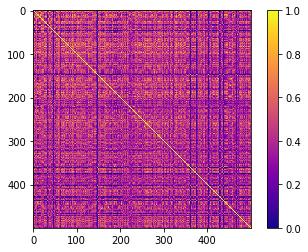

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
m = np.array(top_500_similar_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

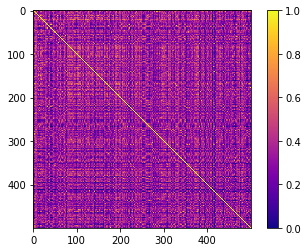

In [11]:
m = np.array(top_500_surprise_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

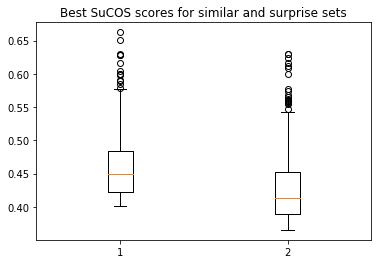

In [12]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best SuCOS scores for similar and surprise sets')
ax7.boxplot([list(best_sucos_similar['best_sucos']), list(best_sucos_surprise['best_sucos'])])

plt.show()

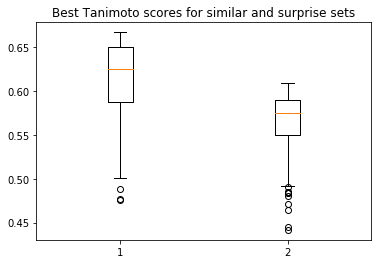

In [13]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best Tanimoto scores for similar and surprise sets')
ax7.boxplot([list(best_tanimoto_similar['best_tanimoto']), list(best_tanimoto_surprise['best_tanimoto'])])

plt.show()

In [14]:
# top_250_similar_diverse, inds_250sd = mols_from_morgan(top_500_similar_mols, 250)  
df250 = best_sucos_similar.iloc[:250]

In [15]:
df250.sort_values(by=['best_sucos'], ascending=False)

,candidate_name,candidate_smiles,candidate_conformers_file,initial_hit,best_sucos,best_sucos_id,best_tanimoto,best_tanimoto_id
730,GDP_frag2-similar-rsn_566,CNC(=S)N1CCOC(C(F)(F)F)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.662476,83,0.566098,12
1364,GDP_frag2-similar-rsn_610,CNC(=S)N1CC(CO)OC(C(F)(F)F)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.650553,61,0.523268,13
843,GDP_frag2-similar-rsn_729,CNC(=S)N1CCOC(CO)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.629860,56,0.567248,74
207,GDP_frag2-similar-rsn_206,OC1COCC1F,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.628993,44,0.733401,44
402,GDP_frag2-similar-rsn_784,OC1COCC1O,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.628912,53,0.734927,53
169,GDP_frag2-similar-rsn_550,COCC1C[NH2+]CCO1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.616389,23,0.659960,88
850,GDP_frag2-similar-rsn_430,CNC(=S)NC1COCC1OC,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.604582,64,0.559946,23
786,GDP_frag2-similar-rsn_163,COCC(O)CO,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.599886,25,0.714918,29
671,GDP_frag2-similar-rsn_362,CNC(=S)N1CCC(CO)(OC)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.599144,55,0.524893,48
48,GDP_frag2-similar-rsn_365,CNC(=S)N1CCOCC(O)C1,/data/GDP_frags/GDP_frag2/GDP_frag2-similar-rs...,GDP.sdf,0.598655,62,0.578967,47


In [16]:
df = df250.sort_values(by=['best_sucos'], ascending=False)

df250_mols = mols_from_df(df)
# top_250_similar_diverse_mat = compare_mols_sucos(df250_mols)

In [ ]:
# m = np.array(top_250_similar_diverse_mat)
# plt.imshow(m, interpolation='nearest', cmap='plasma')
# plt.colorbar()
# plt.show()

In [ ]:
# nl = []
# for l in top_500_similar_mat[:250]:
#     nl.append(l[:250])
# m = np.array(nl)
# plt.imshow(m, interpolation='nearest', cmap='plasma')
# plt.colorbar()
# plt.show()

In [ ]:
# fig7, ax7 = plt.subplots()
# ax7.set_title('Best SuCOS scores for similar_diverse_250 and similar_500')
# ax7.boxplot([list(df['best_sucos']), list(best_sucos_similar['best_sucos'])])

# plt.show()

In [17]:
best_sucos_surprise.iloc[:250].to_csv('/data/GDP_frags/GDP_frag2/250_surprise_sucos.csv')

In [18]:
df.to_csv('/data/GDP_frags/GDP_frag2/250_similar_sucos_diverse.csv')

In [19]:
writer = Chem.SDWriter('/data/GDP_frags/GDP_frag2/250_similar_sucos_diverse.sdf')
for mol in df250_mols:
    writer.write(mol)

In [20]:
writer = Chem.SDWriter('/data/GDP_frags/GDP_frag2/250_surprise_sucos.sdf')
for mol in top_500_surprise_mols[:250]:
    writer.write(mol)